In [ ]:
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets,models,transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from torch.nn import Parameter
from collections.abc import Iterable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/densenet201/densenet201_3.pth'

In [ ]:
from collections.abc import Iterable

def set_freeze_by_idxs(model, idxs, freeze=True):
    if not isinstance(idxs, Iterable):
        idxs = [idxs]
    num_child = len(list(model.children()))
    idxs = tuple(map(lambda idx: num_child + idx if idx < 0 else idx, idxs))
    for idx, child in enumerate(model.children()):
        if idx not in idxs:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze
    return model

def freeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, True)

def unfreeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, False)
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad=False
    return model
def initialize_model(model_name,num_classes,use_pretrained,unfreeze_num):
    if model_name=='vgg16':
        model_pre=models.vgg16(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier[6].in_features
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes)
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='vgg19':
        model_pre=models.vgg19(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier[6].in_features
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes)
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet101':
        model_pre=models.resnet101(pretrained=use_pretrained)
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features
        model_pre.fc=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet152':
        model_pre=models.resnet152(pretrained=use_pretrained)
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features
        model_pre.fc=nn.Linear(num_ftrs,num_classes)

        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet161':
        model_pre=models.densenet161(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet201':
        model_pre=models.densenet201(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    else:
        print('model not implemented')
        return None,None
    return model_pre,input_size

In [ ]:
from pathlib import Path
model_all=[]
dir='/content/drive/MyDrive/'
def auto_net(model_name,num_classes,use_pretrained,unfreeze_num):
    
    for k in range(unfreeze_num):
        model,input_size=initialize_model(model_name,num_classes,use_pretrained,k+1)
        my_path=Path(dir+'/{}'.format(model_name))
        if not my_path.is_dir(): 
            os.mkdir(my_path)
        torch.save(model,dir+'/{}/{}_{}.pth'.format(model_name,model_name,k))
            
        model_all.append(model)

    return model_all
model_name=['vgg16','vgg19','resnet101','resnet152','densenet161','densenet201']
model_all=auto_net(model_name[5],num_classes=3,use_pretrained=True,unfreeze_num=4)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CS539/dataaset/train-delete.txt', sep=" ", header=None)
train_df=train_df.drop([2,3,4,5], axis=1 )
train_df=train_df.rename(columns={0:'filename',1:'label'})

In [ ]:
train_df

,filename,label
0,NCP_96_1328_0032.png,2
1,NCP_96_1328_0035.png,2
2,NCP_96_1328_0036.png,2
3,NCP_96_1328_0037.png,2
4,NCP_96_1328_0038.png,2
...,...,...
14995,Normal_742_177_0031.png,0
14996,Normal_742_177_0032.png,0
14997,Normal_742_177_0033.png,0
14998,Normal_742_177_0034.png,0


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/CS539/dataaset/test-delete.txt', sep=" ", header=None)
test_df=test_df.drop([2,3,4,5], axis=1 )
test_df=test_df.rename(columns={0:'filename',1:'label'})

In [ ]:
test_df.label.value_counts()

2    500
1    500
0    500
Name: label, dtype: int64

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/CS539/dataaset/val-delete.txt', sep=" ", header=None)
val_df=val_df.drop([2,3,4,5], axis=1 )
val_df=val_df.rename(columns={0:'filename',1:'label'})

In [ ]:
val_df.label.value_counts()

2    500
1    500
0    500
Name: label, dtype: int64

In [ ]:
image_path = '/content/drive/MyDrive/CS539/dataaset/2A_images/'
train_df['filename'] = image_path+train_df['filename']
val_df['filename'] = image_path+val_df['filename']
test_df['filename'] = image_path + test_df['filename']
train_df.head()

,filename,label
0,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
1,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
2,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
3,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
4,/content/drive/MyDrive/CS539/dataaset/2A_image...,2


In [ ]:
#N  = train_df[train_df['label']==0]
#P = train_df[train_df['label']==1]
#C = train_df[train_df['label']==2]
#from sklearn.utils import resample
#N_download = resample(N, replace = True, n_samples = 100,random_state=0)
#C_download = resample(C, replace = True, n_samples = 100,random_state=0)
#P_download = resample(P, replace = True, n_samples = 100,random_state=0)
#train_df = pd.concat([N_download, P_download, C_download])
#train_df.label.value_counts()

In [ ]:
#N_v  = val_df[val_df['label']==0]
#P_v = val_df[val_df['label']==1]
#C_v = val_df[val_df['label']==2]
#from sklearn.utils import resample
#N_v_download = resample(N_v, replace = True, n_samples = 10,random_state=0)
#P_v_download = resample(P_v, replace = True, n_samples = 10,random_state=0)
#C_v_download = resample(C_v, replace = True, n_samples = 10,random_state=0)
#val_df = pd.concat([N_v_download, P_v_download, C_v_download])
#val_df.label.value_counts()

In [ ]:
train_df = shuffle(train_df)
val_df = shuffle(val_df)
test_df = shuffle(test_df)
train_df.head()

,filename,label
3641,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
4425,/content/drive/MyDrive/CS539/dataaset/2A_image...,2
5926,/content/drive/MyDrive/CS539/dataaset/2A_image...,1
11755,/content/drive/MyDrive/CS539/dataaset/2A_image...,0
9660,/content/drive/MyDrive/CS539/dataaset/2A_image...,1


In [ ]:
labels={0:'Normal',1:'Pneumonia',2:'COVID-19'}
class_names=['Normal','Pneumonia','COVID-19']

train_df['label_n']=[labels[b] for b in train_df['label']]
val_df['label_n']=[labels[b] for b in val_df['label']]
test_df['label_n']=[labels[b] for b in test_df['label']]
train_df[train_df['filename']=='/content/drive/MyDrive/CS539/dataaset/2A_images/Normal_1679_834_0027.png']

,filename,label,label_n
12793,/content/drive/MyDrive/CS539/dataaset/2A_image...,0,Normal


In [ ]:
train_df=train_df.reset_index()
val_df=val_df.reset_index()
test_df=test_df.reset_index()

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, dataset_df, transform=None):
        self.dataset_df = dataset_df
        self.transform = transform
        
    def __len__(self):
        return self.dataset_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.dataset_df['filename'][idx]
        img = Image.open(image_name)
        label = self.dataset_df['label'][idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
batch_size = 64
input_channel = 1
input_size = (224,224)
crop_size=(340,380)
num_classes=3
num_epochs = 21

In [ ]:
transform = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.6349431],[0.32605055])
    ]),
    'test':transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.63507175],[0.3278614])
    ])
}

In [ ]:
dataset_names=['train','val','test']
image_transforms = {'train':transform['train'], 'val':transform['test'],'test':transform['test']}

train_dataset = CovidDataset(train_df, transform=image_transforms['train'])
val_dataset = CovidDataset(val_df, transform=image_transforms['val'])
test_dataset = CovidDataset(test_df, transform=image_transforms['test'])

image_dataset = {'train':train_dataset, 'val':val_dataset,'test':test_dataset}

dataloaders = {x:DataLoader(image_dataset[x],batch_size=batch_size,shuffle=True,num_workers=4) for x in dataset_names}

dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
 
    cm=cm.numpy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm=cm.astype('int')
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '{:.2f}' if normalize else '{}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(i, j, fmt.format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1
    return conf_matrix

def calculate_all_prediction(conf_matrix):
    '''
    总精度：对角线上所有值除以总数
    '''
    total_sum = conf_matrix.sum()
    correct_sum = (np.diag(conf_matrix)).sum()
    prediction = round(100*float(correct_sum)/float(total_sum),2)
    return prediction

def calculate_label_prediction(conf_matrix,labelidx):
    '''
    预测精度：该类被预测正确的数除以该类的总数
    '''
    label_total_sum = conf_matrix.sum(axis=0)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    prediction = 0
    if label_total_sum != 0:
        prediction = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return prediction
 
def calculate_label_recall(conf_matrix,labelidx):
    '''
    召回率：
    '''
    label_total_sum = conf_matrix.sum(axis=1)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    recall = 0
    if label_total_sum != 0:
        recall = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return recall
 
def calculate_f1(prediction,recall):
    if (prediction+recall)==0:
        return 0
    return round(2*prediction*recall/(prediction+recall),2)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=torch.load(path)
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9, 0.999))

In [ ]:
def train(model,epoch,num_epochs,criterion,optimizer):
    model.train()
    print('-' * 100)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    running_loss = 0.0
    running_corrects = 0
    for idx, (inputs, labels) in enumerate(dataloaders['train']):
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        #反向传播及更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 99:
            print('train iteration:{},loss:{},acc:{}%'.format( idx, loss.item(),torch.sum(preds == labels.data)/batch_size*100))
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print('train_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

In [ ]:
def test(model,epoch,num_epochs,criterion,optimizer,best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_acc=best_acc
    best_model_wts=copy.deepcopy(model.state_dict())
    conf_matrix = torch.zeros(num_classes, num_classes) # 混淆矩阵初始化
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            conf_matrix = confusion_matrix(outputs, labels, conf_matrix) # 生成混淆矩阵

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) #preds是tensor,labels.data是tensor

        plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='confusion matrix') # 混淆矩阵的可视化
        epoch_loss = running_loss / dataset_sizes['val'] 
    epoch_acc = running_corrects.double() / dataset_sizes['val'] #type为tensor
    print('val_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

    all_prediction = calculate_all_prediction(conf_matrix) # 总精度=准确率
    print('all_prediction:{}'.format(all_prediction))
    label_prediction = [] # 存放每个类的精确率
    label_recall = [] # 存放每个类的召回率
    for i in range(num_classes):
        label_prediction.append(calculate_label_prediction(conf_matrix,i))
        label_recall.append(calculate_label_recall(conf_matrix,i))

    keys=class_names
    values=list(range(num_classes))
    dictionary = dict(zip(keys, values))
    for ei,i in enumerate(dictionary):
        print(ei,'\t',i,'\t','prediction=',label_prediction[ei],'%,\trecall=',label_recall[ei],'%,\tf1=',calculate_f1(label_prediction[ei],label_recall[ei])) # 输出每个类的，精确率，召回率，F1
    p = round(np.array(label_prediction).sum()/len(label_prediction),2) # 总精确率
    r = round(np.array(label_recall).sum()/len(label_prediction),2) # 总召回率
    print('MACRO-averaged:\nprediction=',p,'%,recall=',r,'%,f1=',calculate_f1(p,r)) #输出总精确率和召回率
    if epoch_acc > best_acc:# 获取最好的模型和准确率
        best_acc=epoch_acc.item()
        best_model_wts=copy.deepcopy(model.state_dict())
#     model.load_state_dict(best_model_wts)

    return best_model_wts,best_acc,epoch_acc.item()

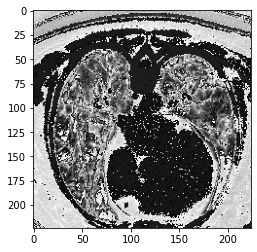

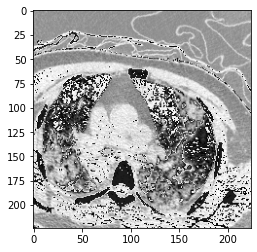

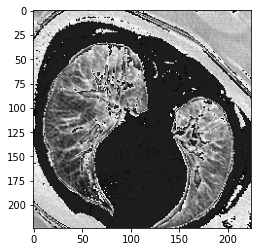

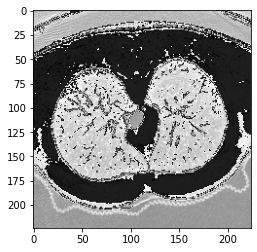

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
def show_tensor_img(tensor_img):
    img=transforms.ToPILImage()(tensor_img)
    plt.figure()
    plt.imshow(img,plt.cm.gray)
    plt.show()

def show_img(idx):
  show_tensor_img(train_dataset[idx][0])
for i in range(4):
    show_img(i)

----------------------------------------------------------------------------------------------------
Epoch 0/20
train iteration:99,loss:0.0007282951264642179,acc:100.0%
train iteration:199,loss:0.0037897343281656504,acc:100.0%
train_total Loss: 0.0045 Acc: 99.9133%
Confusion matrix, without normalization


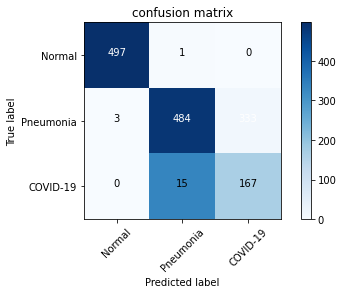

val_total Loss: 0.7527 Acc: 76.5333%
all_prediction:76.53
0 	 Normal 	 prediction= 99.8 %,	recall= 99.4 %,	f1= 99.6
1 	 Pneumonia 	 prediction= 59.02 %,	recall= 96.8 %,	f1= 73.33
2 	 COVID-19 	 prediction= 91.76 %,	recall= 33.4 %,	f1= 48.97
MACRO-averaged:
prediction= 83.53 %,recall= 76.53 %,f1= 79.88
----------------------------------------------------------------------------------------------------
Epoch 1/20
train iteration:99,loss:0.001077456516213715,acc:100.0%
train iteration:199,loss:0.0023814768064767122,acc:100.0%
train_total Loss: 0.0032 Acc: 99.9400%
Confusion matrix, without normalization


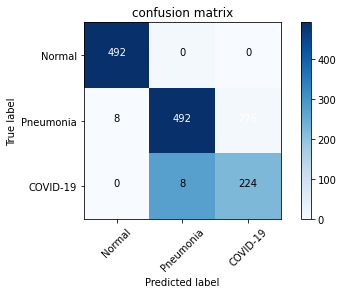

val_total Loss: 0.5903 Acc: 80.5333%
all_prediction:80.53
0 	 Normal 	 prediction= 100.0 %,	recall= 98.4 %,	f1= 99.19
1 	 Pneumonia 	 prediction= 63.4 %,	recall= 98.4 %,	f1= 77.11
2 	 COVID-19 	 prediction= 96.55 %,	recall= 44.8 %,	f1= 61.2
MACRO-averaged:
prediction= 86.65 %,recall= 80.53 %,f1= 83.48
----------------------------------------------------------------------------------------------------
Epoch 2/20
train iteration:99,loss:0.0007674482767470181,acc:100.0%
train iteration:199,loss:0.0005144246970303357,acc:100.0%
train_total Loss: 0.0019 Acc: 99.9867%
Confusion matrix, without normalization


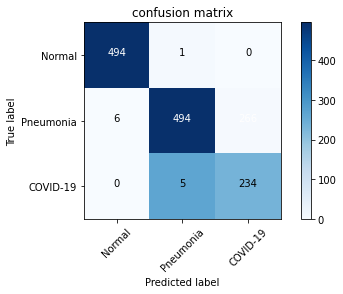

val_total Loss: 0.5300 Acc: 81.4667%
all_prediction:81.47
0 	 Normal 	 prediction= 99.8 %,	recall= 98.8 %,	f1= 99.3
1 	 Pneumonia 	 prediction= 64.49 %,	recall= 98.8 %,	f1= 78.04
2 	 COVID-19 	 prediction= 97.91 %,	recall= 46.8 %,	f1= 63.33
MACRO-averaged:
prediction= 87.4 %,recall= 81.47 %,f1= 84.33
----------------------------------------------------------------------------------------------------
Epoch 3/20
train iteration:99,loss:0.002826804295182228,acc:100.0%
train iteration:199,loss:0.0008816759218461812,acc:100.0%
train_total Loss: 0.0018 Acc: 99.9733%
Confusion matrix, without normalization


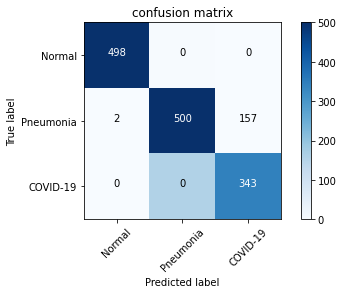

val_total Loss: 0.3141 Acc: 89.4000%
all_prediction:89.4
0 	 Normal 	 prediction= 100.0 %,	recall= 99.6 %,	f1= 99.8
1 	 Pneumonia 	 prediction= 75.87 %,	recall= 100.0 %,	f1= 86.28
2 	 COVID-19 	 prediction= 100.0 %,	recall= 68.6 %,	f1= 81.38
MACRO-averaged:
prediction= 91.96 %,recall= 89.4 %,f1= 90.66
----------------------------------------------------------------------------------------------------
Epoch 4/20
train iteration:99,loss:0.005665548145771027,acc:100.0%
train iteration:199,loss:0.001661570044234395,acc:100.0%
train_total Loss: 0.0033 Acc: 99.9267%
Confusion matrix, without normalization


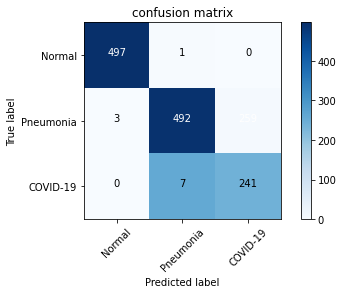

val_total Loss: 0.3858 Acc: 82.0000%
all_prediction:82.0
0 	 Normal 	 prediction= 99.8 %,	recall= 99.4 %,	f1= 99.6
1 	 Pneumonia 	 prediction= 65.25 %,	recall= 98.4 %,	f1= 78.47
2 	 COVID-19 	 prediction= 97.18 %,	recall= 48.2 %,	f1= 64.44
MACRO-averaged:
prediction= 87.41 %,recall= 82.0 %,f1= 84.62
----------------------------------------------------------------------------------------------------
Epoch 5/20
train iteration:99,loss:0.0030585068743675947,acc:100.0%
train iteration:199,loss:0.0020150793716311455,acc:100.0%
train_total Loss: 0.0021 Acc: 99.9733%
Confusion matrix, without normalization


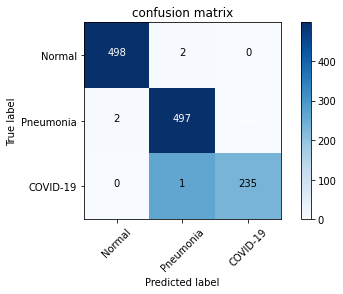

val_total Loss: 0.5304 Acc: 82.0000%
all_prediction:82.0
0 	 Normal 	 prediction= 99.6 %,	recall= 99.6 %,	f1= 99.6
1 	 Pneumonia 	 prediction= 65.05 %,	recall= 99.4 %,	f1= 78.64
2 	 COVID-19 	 prediction= 99.58 %,	recall= 47.0 %,	f1= 63.86
MACRO-averaged:
prediction= 88.08 %,recall= 82.0 %,f1= 84.93
----------------------------------------------------------------------------------------------------
Epoch 6/20
train iteration:99,loss:0.00028093988657929003,acc:100.0%
train iteration:199,loss:0.00022750961943529546,acc:100.0%
train_total Loss: 0.0020 Acc: 99.9667%
Confusion matrix, without normalization


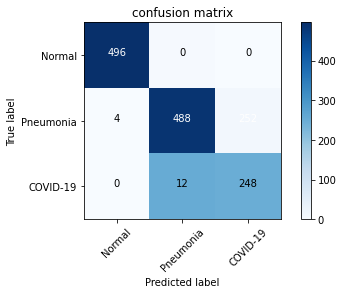

val_total Loss: 0.5578 Acc: 82.1333%
all_prediction:82.13
0 	 Normal 	 prediction= 100.0 %,	recall= 99.2 %,	f1= 99.6
1 	 Pneumonia 	 prediction= 65.59 %,	recall= 97.6 %,	f1= 78.46
2 	 COVID-19 	 prediction= 95.38 %,	recall= 49.6 %,	f1= 65.26
MACRO-averaged:
prediction= 86.99 %,recall= 82.13 %,f1= 84.49
----------------------------------------------------------------------------------------------------
Epoch 7/20
train iteration:99,loss:0.0002467203885316849,acc:100.0%
train iteration:199,loss:0.005447933916002512,acc:100.0%
train_total Loss: 0.0019 Acc: 99.9533%
Confusion matrix, without normalization


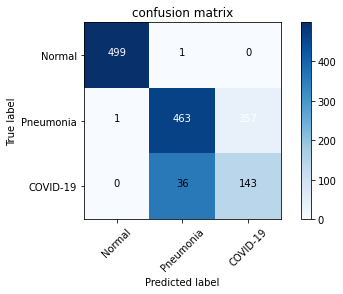

val_total Loss: 0.9802 Acc: 73.6667%
all_prediction:73.67
0 	 Normal 	 prediction= 99.8 %,	recall= 99.8 %,	f1= 99.8
1 	 Pneumonia 	 prediction= 56.39 %,	recall= 92.6 %,	f1= 70.09
2 	 COVID-19 	 prediction= 79.89 %,	recall= 28.6 %,	f1= 42.12
MACRO-averaged:
prediction= 78.69 %,recall= 73.67 %,f1= 76.1
----------------------------------------------------------------------------------------------------
Epoch 8/20
train iteration:99,loss:0.004175861366093159,acc:100.0%
train iteration:199,loss:0.003283113008365035,acc:100.0%
train_total Loss: 0.0010 Acc: 100.0000%
Confusion matrix, without normalization


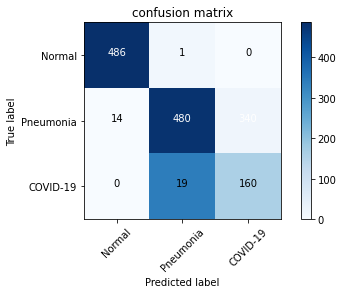

val_total Loss: 0.9403 Acc: 75.0667%
all_prediction:75.07
0 	 Normal 	 prediction= 99.79 %,	recall= 97.2 %,	f1= 98.48
1 	 Pneumonia 	 prediction= 57.55 %,	recall= 96.0 %,	f1= 71.96
2 	 COVID-19 	 prediction= 89.39 %,	recall= 32.0 %,	f1= 47.13
MACRO-averaged:
prediction= 82.24 %,recall= 75.07 %,f1= 78.49
----------------------------------------------------------------------------------------------------
Epoch 9/20
train iteration:99,loss:0.0016525954706594348,acc:100.0%
train iteration:199,loss:0.0002772469015326351,acc:100.0%
train_total Loss: 0.0024 Acc: 99.9400%
Confusion matrix, without normalization


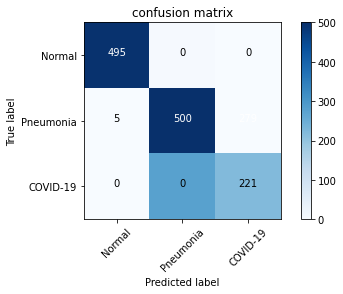

val_total Loss: 0.6291 Acc: 81.0667%
all_prediction:81.07
0 	 Normal 	 prediction= 100.0 %,	recall= 99.0 %,	f1= 99.5
1 	 Pneumonia 	 prediction= 63.78 %,	recall= 100.0 %,	f1= 77.88
2 	 COVID-19 	 prediction= 100.0 %,	recall= 44.2 %,	f1= 61.3
MACRO-averaged:
prediction= 87.93 %,recall= 81.07 %,f1= 84.36
----------------------------------------------------------------------------------------------------
Epoch 10/20
train iteration:99,loss:0.0013707381440326571,acc:100.0%
train iteration:199,loss:0.00010128231951966882,acc:100.0%
train_total Loss: 0.0015 Acc: 99.9733%
Confusion matrix, without normalization


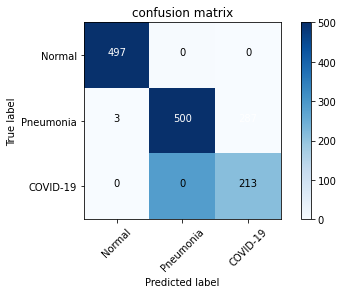

val_total Loss: 0.6027 Acc: 80.6667%
all_prediction:80.67
0 	 Normal 	 prediction= 100.0 %,	recall= 99.4 %,	f1= 99.7
1 	 Pneumonia 	 prediction= 63.29 %,	recall= 100.0 %,	f1= 77.52
2 	 COVID-19 	 prediction= 100.0 %,	recall= 42.6 %,	f1= 59.75
MACRO-averaged:
prediction= 87.76 %,recall= 80.67 %,f1= 84.07
----------------------------------------------------------------------------------------------------
Epoch 11/20
train iteration:99,loss:0.0008888585725799203,acc:100.0%
train iteration:199,loss:0.0006797761889174581,acc:100.0%
train_total Loss: 0.0013 Acc: 99.9800%
Confusion matrix, without normalization


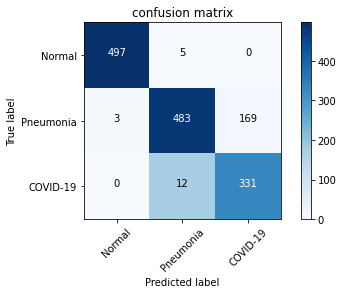

val_total Loss: 0.3205 Acc: 87.4000%
all_prediction:87.4
0 	 Normal 	 prediction= 99.0 %,	recall= 99.4 %,	f1= 99.2
1 	 Pneumonia 	 prediction= 73.74 %,	recall= 96.6 %,	f1= 83.64
2 	 COVID-19 	 prediction= 96.5 %,	recall= 66.2 %,	f1= 78.53
MACRO-averaged:
prediction= 89.75 %,recall= 87.4 %,f1= 88.56
----------------------------------------------------------------------------------------------------
Epoch 12/20
train iteration:99,loss:0.00012192738358862698,acc:100.0%
train iteration:199,loss:0.0008930056355893612,acc:100.0%
train_total Loss: 0.0010 Acc: 99.9733%
Confusion matrix, without normalization


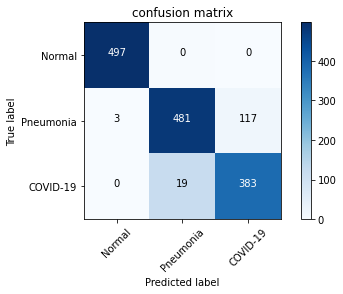

val_total Loss: 0.2368 Acc: 90.7333%
all_prediction:90.73
0 	 Normal 	 prediction= 100.0 %,	recall= 99.4 %,	f1= 99.7
1 	 Pneumonia 	 prediction= 80.03 %,	recall= 96.2 %,	f1= 87.37
2 	 COVID-19 	 prediction= 95.27 %,	recall= 76.6 %,	f1= 84.92
MACRO-averaged:
prediction= 91.77 %,recall= 90.73 %,f1= 91.25
----------------------------------------------------------------------------------------------------
Epoch 13/20
train iteration:99,loss:5.205700290389359e-05,acc:100.0%
train iteration:199,loss:0.00038199248956516385,acc:100.0%
train_total Loss: 0.0023 Acc: 99.9400%
Confusion matrix, without normalization


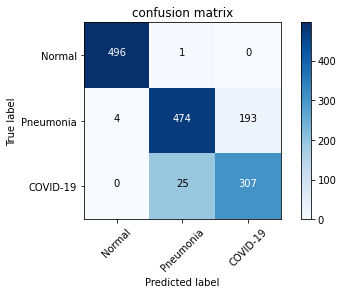

val_total Loss: 0.4156 Acc: 85.1333%
all_prediction:85.13
0 	 Normal 	 prediction= 99.8 %,	recall= 99.2 %,	f1= 99.5
1 	 Pneumonia 	 prediction= 70.64 %,	recall= 94.8 %,	f1= 80.96
2 	 COVID-19 	 prediction= 92.47 %,	recall= 61.4 %,	f1= 73.8
MACRO-averaged:
prediction= 87.64 %,recall= 85.13 %,f1= 86.37
----------------------------------------------------------------------------------------------------
Epoch 14/20
train iteration:99,loss:0.0007840897305868566,acc:100.0%
train iteration:199,loss:0.0003853689122479409,acc:100.0%
train_total Loss: 0.0015 Acc: 99.9667%
Confusion matrix, without normalization


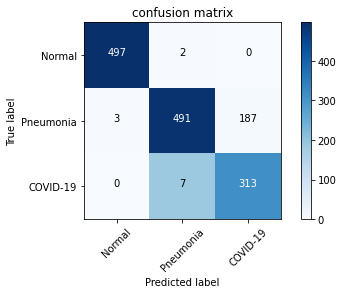

val_total Loss: 0.3870 Acc: 86.7333%
all_prediction:86.73
0 	 Normal 	 prediction= 99.6 %,	recall= 99.4 %,	f1= 99.5
1 	 Pneumonia 	 prediction= 72.1 %,	recall= 98.2 %,	f1= 83.15
2 	 COVID-19 	 prediction= 97.81 %,	recall= 62.6 %,	f1= 76.34
MACRO-averaged:
prediction= 89.84 %,recall= 86.73 %,f1= 88.26
----------------------------------------------------------------------------------------------------
Epoch 15/20
train iteration:99,loss:0.00020170980133116245,acc:100.0%
train iteration:199,loss:0.00262812408618629,acc:100.0%
train_total Loss: 0.0010 Acc: 99.9733%
Confusion matrix, without normalization


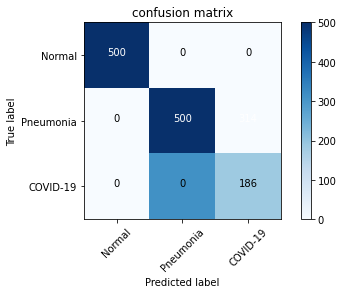

val_total Loss: 0.8330 Acc: 79.0667%
all_prediction:79.07
0 	 Normal 	 prediction= 100.0 %,	recall= 100.0 %,	f1= 100.0
1 	 Pneumonia 	 prediction= 61.43 %,	recall= 100.0 %,	f1= 76.11
2 	 COVID-19 	 prediction= 100.0 %,	recall= 37.2 %,	f1= 54.23
MACRO-averaged:
prediction= 87.14 %,recall= 79.07 %,f1= 82.91
----------------------------------------------------------------------------------------------------
Epoch 16/20
train iteration:99,loss:6.066046262276359e-05,acc:100.0%
train iteration:199,loss:0.001508803921751678,acc:100.0%
train_total Loss: 0.0010 Acc: 99.9933%
Confusion matrix, without normalization


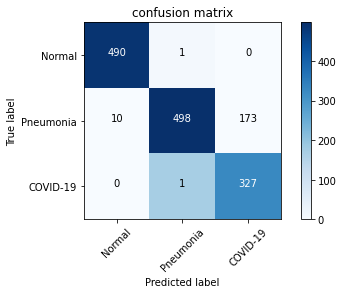

val_total Loss: 0.4023 Acc: 87.6667%
all_prediction:87.67
0 	 Normal 	 prediction= 99.8 %,	recall= 98.0 %,	f1= 98.89
1 	 Pneumonia 	 prediction= 73.13 %,	recall= 99.6 %,	f1= 84.34
2 	 COVID-19 	 prediction= 99.7 %,	recall= 65.4 %,	f1= 78.99
MACRO-averaged:
prediction= 90.88 %,recall= 87.67 %,f1= 89.25
----------------------------------------------------------------------------------------------------
Epoch 17/20
train iteration:99,loss:0.0002805004478432238,acc:100.0%
train iteration:199,loss:5.4746771638747305e-05,acc:100.0%
train_total Loss: 0.0016 Acc: 99.9467%
Confusion matrix, without normalization


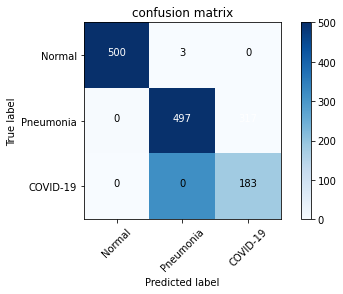

val_total Loss: 0.7699 Acc: 78.6667%
all_prediction:78.67
0 	 Normal 	 prediction= 99.4 %,	recall= 100.0 %,	f1= 99.7
1 	 Pneumonia 	 prediction= 61.06 %,	recall= 99.4 %,	f1= 75.65
2 	 COVID-19 	 prediction= 100.0 %,	recall= 36.6 %,	f1= 53.59
MACRO-averaged:
prediction= 86.82 %,recall= 78.67 %,f1= 82.54
----------------------------------------------------------------------------------------------------
Epoch 18/20
train iteration:99,loss:0.00013386859791353345,acc:100.0%
train iteration:199,loss:9.66225125011988e-05,acc:100.0%
train_total Loss: 0.0008 Acc: 99.9933%
Confusion matrix, without normalization


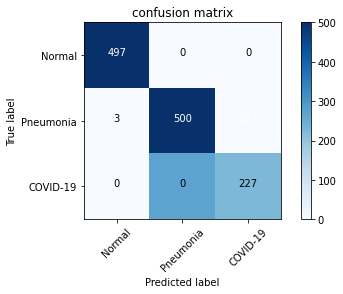

val_total Loss: 0.6728 Acc: 81.6000%
all_prediction:81.6
0 	 Normal 	 prediction= 100.0 %,	recall= 99.4 %,	f1= 99.7
1 	 Pneumonia 	 prediction= 64.43 %,	recall= 100.0 %,	f1= 78.37
2 	 COVID-19 	 prediction= 100.0 %,	recall= 45.4 %,	f1= 62.45
MACRO-averaged:
prediction= 88.14 %,recall= 81.6 %,f1= 84.74
----------------------------------------------------------------------------------------------------
Epoch 19/20
train iteration:99,loss:0.0006474548135884106,acc:100.0%
train iteration:199,loss:0.00033107303897850215,acc:100.0%
train_total Loss: 0.0007 Acc: 99.9933%
Confusion matrix, without normalization


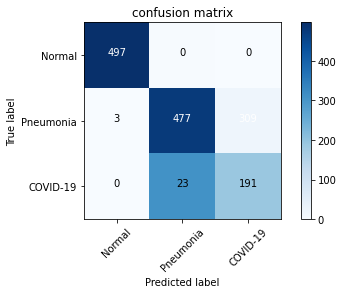

val_total Loss: 0.8384 Acc: 77.6667%
all_prediction:77.67
0 	 Normal 	 prediction= 100.0 %,	recall= 99.4 %,	f1= 99.7
1 	 Pneumonia 	 prediction= 60.46 %,	recall= 95.4 %,	f1= 74.01
2 	 COVID-19 	 prediction= 89.25 %,	recall= 38.2 %,	f1= 53.5
MACRO-averaged:
prediction= 83.24 %,recall= 77.67 %,f1= 80.36
----------------------------------------------------------------------------------------------------
Epoch 20/20
train iteration:99,loss:0.00013180187670513988,acc:100.0%
train iteration:199,loss:6.140454934211448e-05,acc:100.0%
train_total Loss: 0.0007 Acc: 99.9733%
Confusion matrix, without normalization


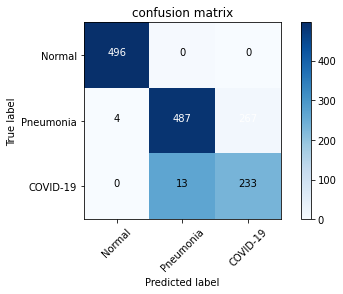

val_total Loss: 0.6512 Acc: 81.0667%
all_prediction:81.07
0 	 Normal 	 prediction= 100.0 %,	recall= 99.2 %,	f1= 99.6
1 	 Pneumonia 	 prediction= 64.25 %,	recall= 97.4 %,	f1= 77.43
2 	 COVID-19 	 prediction= 94.72 %,	recall= 46.6 %,	f1= 62.47
MACRO-averaged:
prediction= 86.32 %,recall= 81.07 %,f1= 83.61
****************************************************************************************************
best_acc:0.9073333333333333
****************************************************************************************************


In [ ]:
if __name__ == '__main__':
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc=[]
    for epoch in range(num_epochs):
        train(model,epoch,num_epochs,criterion,optimizer)
        best_model_wts,best_acc,epoch_acc=test(model,epoch,num_epochs,criterion,optimizer,best_acc)
        acc.append(epoch_acc)
    print('*' * 100)
    print('best_acc:{}'.format(best_acc))
    print('*' * 100)
    torch.save(best_model_wts, 'densenet201_3_model_best_acc.pth')